In [1]:
import pandas as pd
import numpy as np
import mne
from sklearn.model_selection import train_test_split, KFold

In [2]:
DATA_ROOT = '../data/ds004902-download'

In [3]:
class LoadData:
    def __init__(self, root, experiment_type: int, test_size: float = 0.2, random_state: int = 42, k_folds: int = 5):
        """
        ROOT: path to the root directory of the dataset

        Experiment type:
            1: Eyes Closed
            2: Eyes open
            3: Both
        """
        self.DATA_ROOT = root
        self.PARTICIPANTS_TSV = f'{self.DATA_ROOT}/participants.tsv'
        self.experiment_type = experiment_type

        # get class labels
        self.raw_labels = self.get_classes()
        self.labels = []

        # create data examples
        self.raw_data = []
        self.data = []
        self._create_eeg_objects()

        # holdout information
        self.test_size = test_size
        self.random_state = random_state

        # cross-validation information
        self.k_folds = k_folds
        self.split_participants = []

        # train and test data
        self.test = None
        self.train = None

        # split data
        self._cross_validation()
    

    def get_classes(self):
        participant_df = pd.read_csv(self.PARTICIPANTS_TSV, sep='\t')
        session_order = participant_df[['participant_id', 'SessionOrder']]

        # create ses-1 column based on the first two characters of the session order
        session_order['ses-1'] = session_order['SessionOrder'].str[:2]
        session_order['ses-2'] = session_order['SessionOrder'].str[4:]

        session_order = session_order.drop(columns=['SessionOrder'])

        session_order['ses-1'] = session_order['ses-1'].apply(lambda x: 1 if x == 'SD' else 0)
        session_order['ses-2'] = session_order['ses-2'].apply(lambda x: 1 if x == 'SD' else 0)

        return session_order
    
    def _create_eeg_objects(self): 
        def load_raw_eeg(example, root, participant_id, session, task, class_label):
            try:
                aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()
                if class_label:
                    example[f"{task}_sd"] = (aux_eeg, class_label)
                else:
                    example[f"{task}_ns"] = (aux_eeg, class_label)
            except FileNotFoundError:
                print(f"For participant {participant_id}, the file {participant_id}_{session}_task-{task}_eeg.set was not found")
                aux_eeg = None
            except RuntimeError as e:
                print(f"Error loading participant {participant_id} with session {session} and task {task}: {e}")
                aux_eeg = None

            return example

        session_order = self.raw_labels

        for participant_id, ses_1, ses_2 in zip(session_order['participant_id'], session_order['ses-1'], session_order['ses-2']):
            example = dict()
            if self.experiment_type == 1:
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-1', 'eyesclosed', ses_1)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-2', 'eyesclosed', ses_2)
            elif self.experiment_type == 2:
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-1', 'eyesopen', ses_1)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-2', 'eyesopen', ses_2)
            else:
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-1', 'eyesclosed', ses_1)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-2', 'eyesclosed', ses_2)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-1', 'eyesopen', ses_1)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-2', 'eyesopen', ses_2)

            if len(example.keys()):
                print(example.keys())
                example['participant_id'] = participant_id

            self.raw_data.append(example) if example.keys() else None
        
        self.raw_data = np.array(self.raw_data)  


    def _holdout(self, participant_id, participant_index):
        X_train, X_test, y_train, y_test = train_test_split(participant_id, participant_index, test_size=self.test_size, random_state=self.random_state)
        return X_train, X_test, y_train, y_test

    def _cross_validation(self):
        participant_id = np.array([x['participant_id'] for x in self.raw_data])
        participant_index = np.arange(len(participant_id))

        _, _, y_train, y_test_id = self._holdout(participant_id, participant_index)
        
        # save test data
        X_test = [self.raw_data[i][col][0] for i in y_test_id for col in self.raw_data[i].keys() if col != 'participant_id']
        y_test = np.array([self.raw_data[i][col][1] for i in y_test_id for col in self.raw_data[i].keys() if col != 'participant_id'])
        self.test = (X_test, y_test)

        # create splits
        skf = KFold(n_splits=self.k_folds)
        self.split_participants = list(skf.split(y_train))


    def get_split_data(self, split):
        split_ids = self.split_participants[split]
        train_ids, val_ids = split_ids

        X_train =[self.raw_data[i][col][0] for i in train_ids for col in self.raw_data[i].keys() if col != 'participant_id']
        y_train = np.array([self.raw_data[i][col][1] for i in train_ids for col in self.raw_data[i].keys() if col != 'participant_id'])
                
        X_val = [self.raw_data[i][col][0] for i in val_ids for col in self.raw_data[i].keys() if col != 'participant_id']
        y_val = np.array([self.raw_data[i][col][1] for i in val_ids for col in self.raw_data[i].keys() if col != 'participant_id'])

        return X_train, X_val, y_train, y_val

    def __len__(self):
        return len(self.raw_data)

In [4]:
data = LoadData(DATA_ROOT, 2)

C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_order['ses-1'] = session_order['SessionOrder'].str[:2]
C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_order['ses-2'] = session_order['SessionOrder'].str[4:]


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-01\ses-1\eeg\sub-01_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-01\ses-2\eeg\sub-01_ses-2_task-eyesopen_eeg.fdt
Error loading participant sub-01 with session ses-2 and task eyesopen: Incorrect number of samples (6951331 != 9150000), please report this error to MNE-Python developers
dict_keys(['eyesopen_ns'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-02\ses-1\eeg\sub-02_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-02\ses-2\eeg\sub-02_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-d

C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-47\ses-1\eeg\sub-47_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-47\ses-2\eeg\sub-47_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-48\ses-1\eeg\sub-48_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-48\ses-2\eeg\sub-48_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-49\ses-1\eeg\sub-49_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds

C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-52\ses-2\eeg\sub-52_ses-2_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-53\ses-1\eeg\sub-53_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-53\ses-2\eeg\sub-53_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-54\ses-1\eeg\sub-54_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-54\ses-2\eeg\sub-54_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-55\ses-1\eeg\sub-55_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-depri

C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:58: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()
C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()
C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-58\ses-1\eeg\sub-58_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-58\ses-2\eeg\sub-58_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-59\ses-1\eeg\sub-59_ses-1_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-59\ses-2\eeg\sub-59_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-60\ses-1\eeg\sub-60_ses-1_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()
C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-60\ses-2\eeg\sub-60_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-61\ses-1\eeg\sub-61_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-61\ses-2\eeg\sub-61_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_sd', 'eyesopen_ns'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-62\ses-1\eeg\sub-62_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-62\ses-2\eeg\sub-62_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-depri

C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-63\ses-2\eeg\sub-63_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-64\ses-1\eeg\sub-64_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-64\ses-2\eeg\sub-64_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-65\ses-1\eeg\sub-65_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-65\ses-2\eeg\sub-65_ses-2_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_29028\1065084183.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


dict_keys(['eyesopen_sd', 'eyesopen_ns'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-66\ses-1\eeg\sub-66_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-66\ses-2\eeg\sub-66_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-67\ses-1\eeg\sub-67_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-67\ses-2\eeg\sub-67_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_sd', 'eyesopen_ns'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-68\ses-1\eeg\sub-68_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-depri

In [7]:
for i in range(data.k_folds):
    X_train, X_val, y_train, y_val = data.get_split_data(i)
    print(f"Fold {i}")
    print(f"Train length: {len(X_train)}")
    print(f"Train example shape: {X_train[0].shape}")
    print(f"Val length: {len(X_val)}")
    print(f"Val example shape: {X_val[0].shape}")
    print(f"Total: {len(X_train) + len(X_val)}")
    print(f"Total raw data: {len(data.raw_data)}")
    print(f"Total test data: {len(data.test[0])}")
    print("")

Fold 0
Train length: 86
Train example shape: (61, 150000)
Val length: 22
Val example shape: (61, 150000)
Total: 108
Total raw data: 71
Total test data: 29

Fold 1
Train length: 86
Train example shape: (61, 150000)
Val length: 22
Val example shape: (61, 150000)
Total: 108
Total raw data: 71
Total test data: 29

Fold 2
Train length: 87
Train example shape: (61, 150000)
Val length: 21
Val example shape: (61, 150000)
Total: 108
Total raw data: 71
Total test data: 29

Fold 3
Train length: 87
Train example shape: (61, 150000)
Val length: 21
Val example shape: (61, 150000)
Total: 108
Total raw data: 71
Total test data: 29

Fold 4
Train length: 86
Train example shape: (61, 150000)
Val length: 22
Val example shape: (61, 150000)
Total: 108
Total raw data: 71
Total test data: 29



In [10]:
X_train, X_val, y_train, y_val = data.get_split_data(0)

In [13]:
example = X_train[0]

In [15]:
import matplotlib.pyplot as plt

In [20]:
example[0].shape

(150000,)

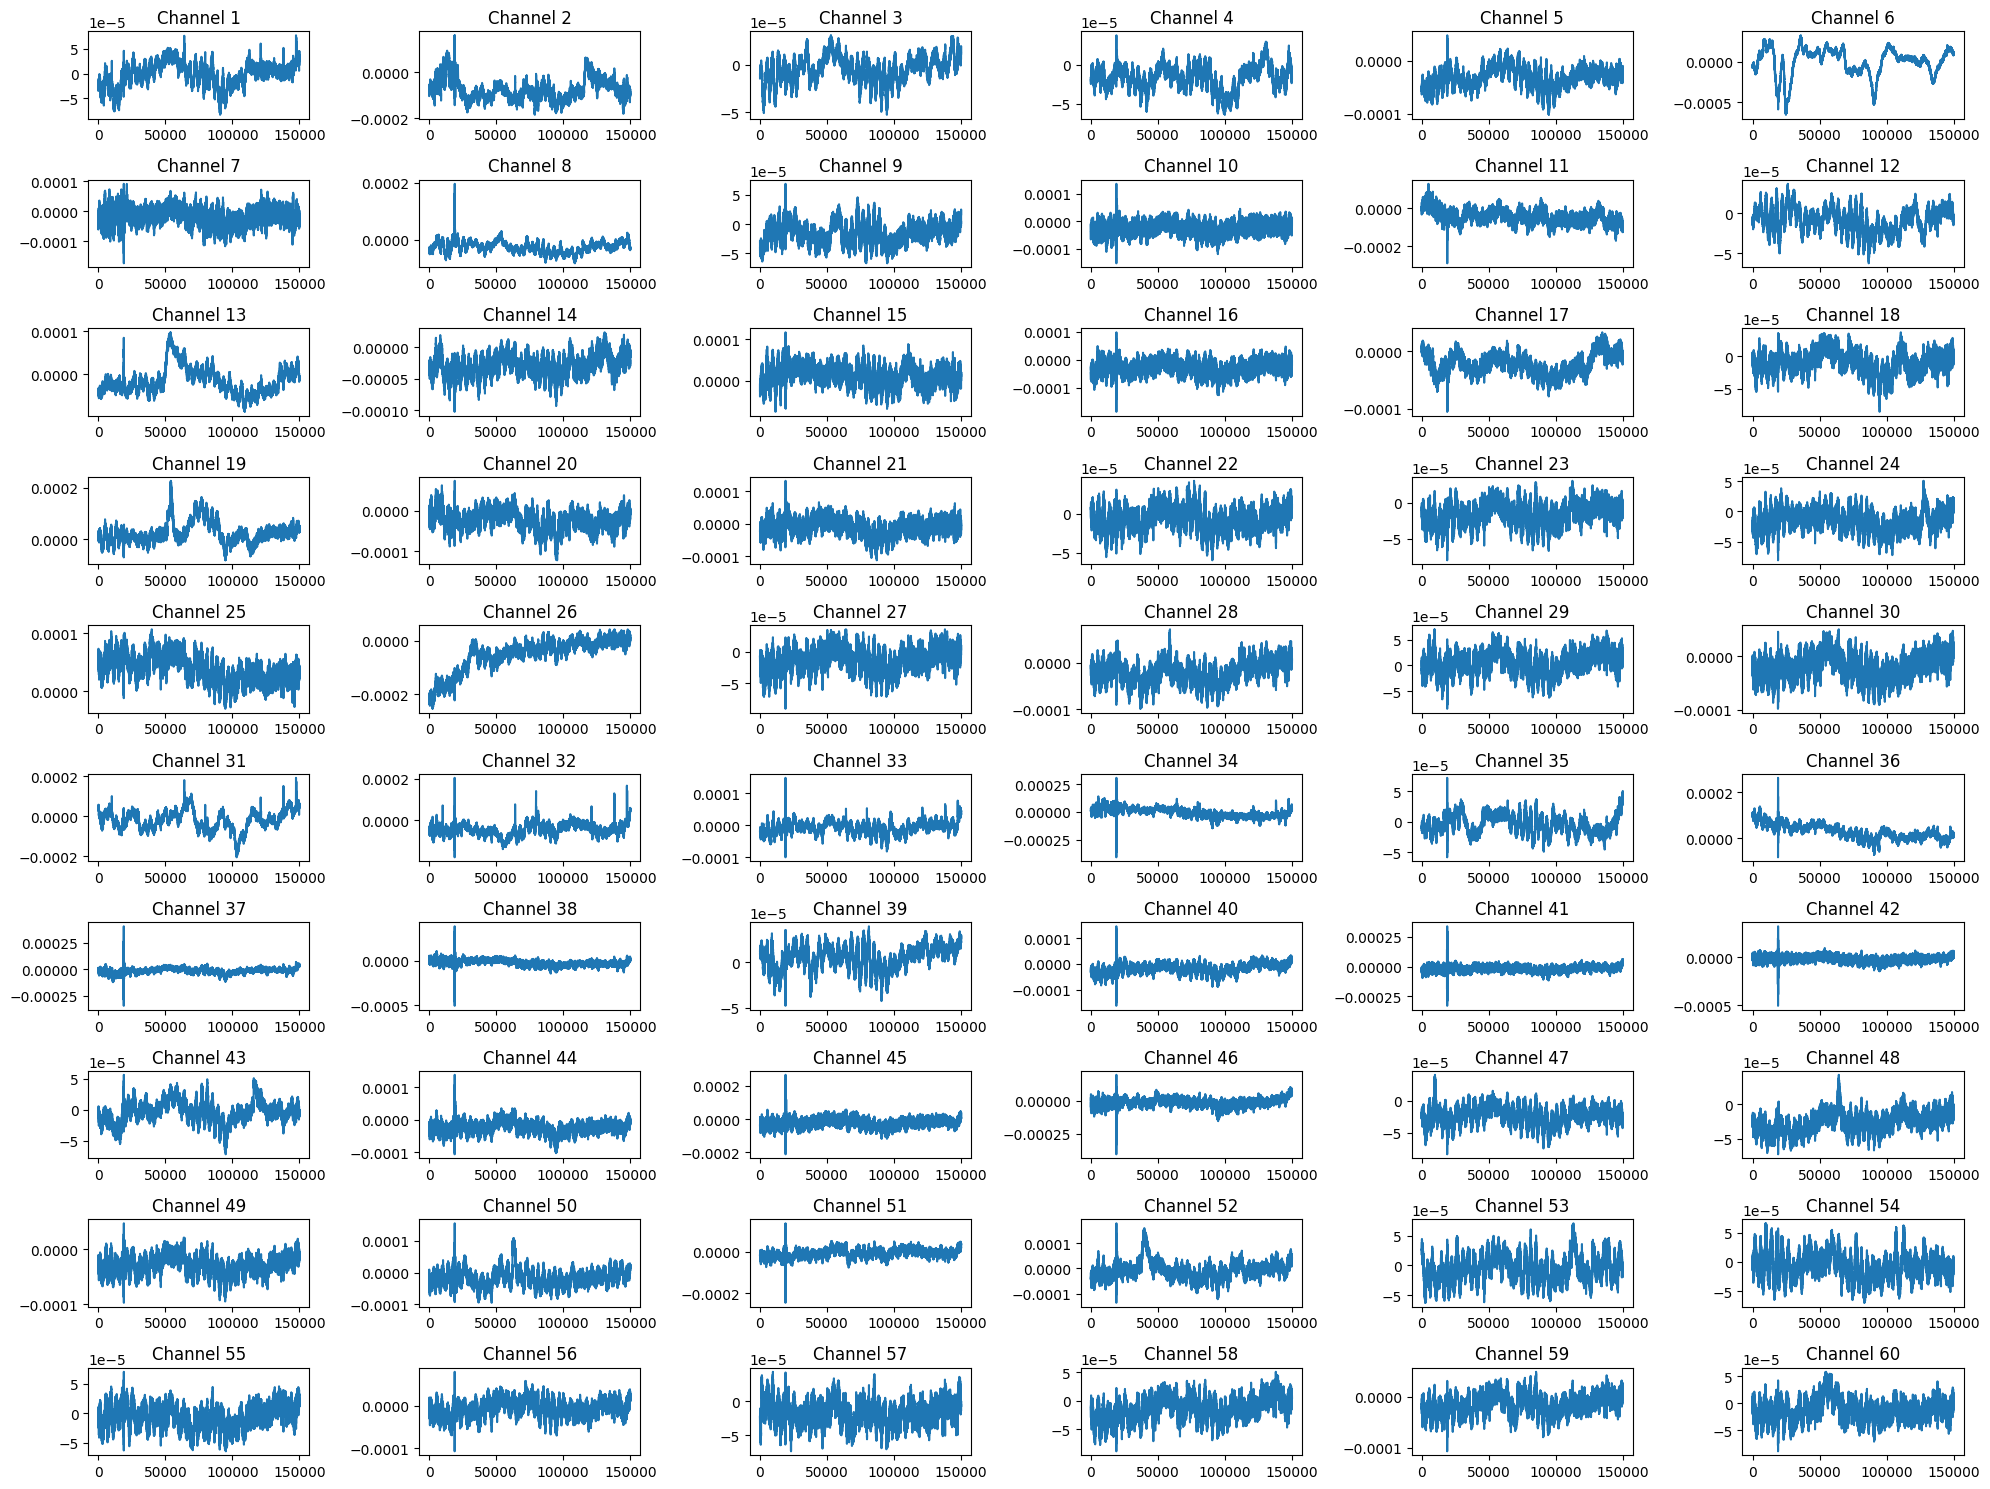

In [32]:
# plot 61 channels
plt.figure(figsize=(20, 15))

# create 10 x 6 grid
for i in range(1, 61):
    plt.subplot(10, 6, i)
    plt.plot(example[i])
    plt.title(f"Channel {i}")

# increase space between plots
plt.tight_layout()
plt.show()



Text(0.5, 1.0, 'Channel 0')

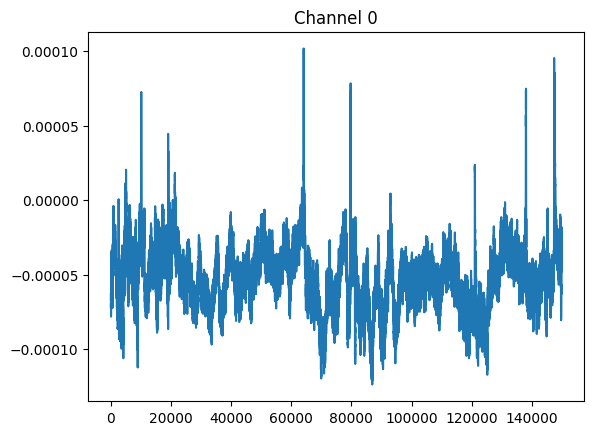

In [33]:
plt.plot(example[0])
plt.title(f"Channel 0")

Text(0.5, 1.0, 'Channel 36')

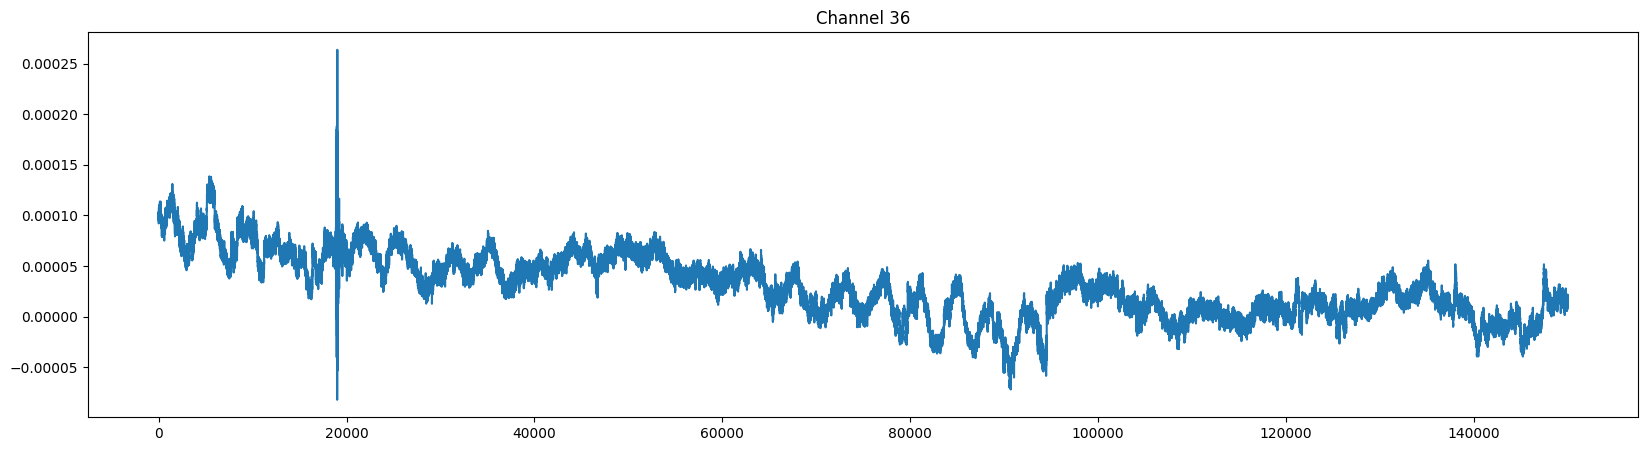

In [38]:
plt.figure(figsize=(20, 5))
plt.plot(example[36])
plt.title(f"Channel 36")

Weird outlier like amplitude.

Text(0.5, 1.0, 'Channel 43')

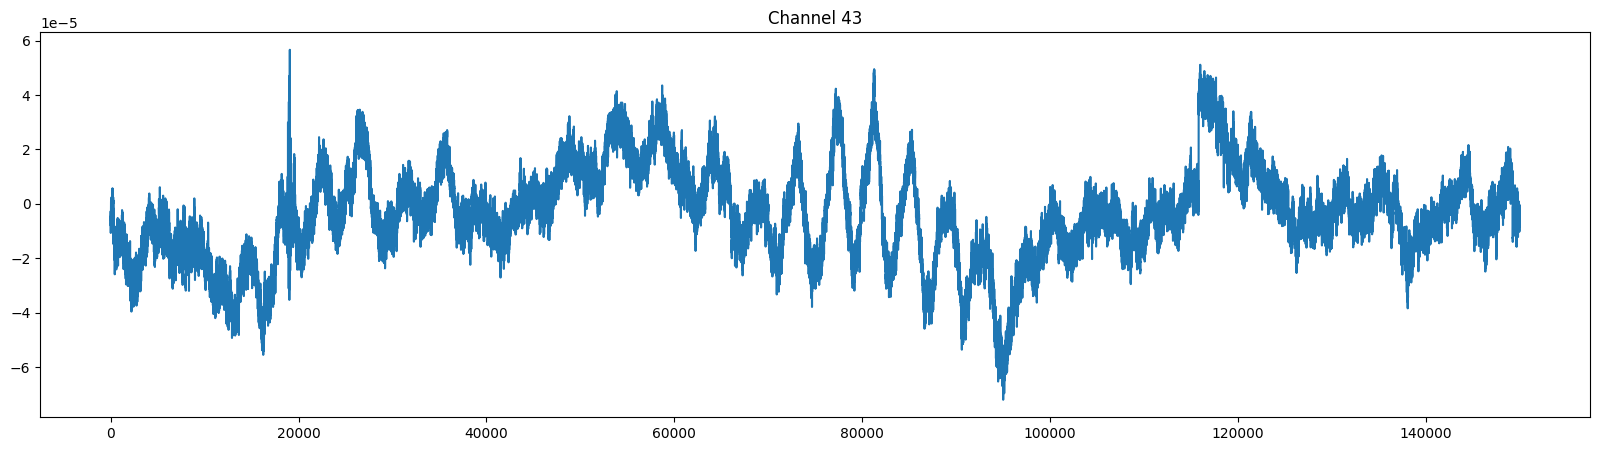

In [40]:
plt.figure(figsize=(20, 5))
plt.plot(example[43])
plt.title(f"Channel 43")

Text(0.5, 1.0, 'Min and Max values of each channel')

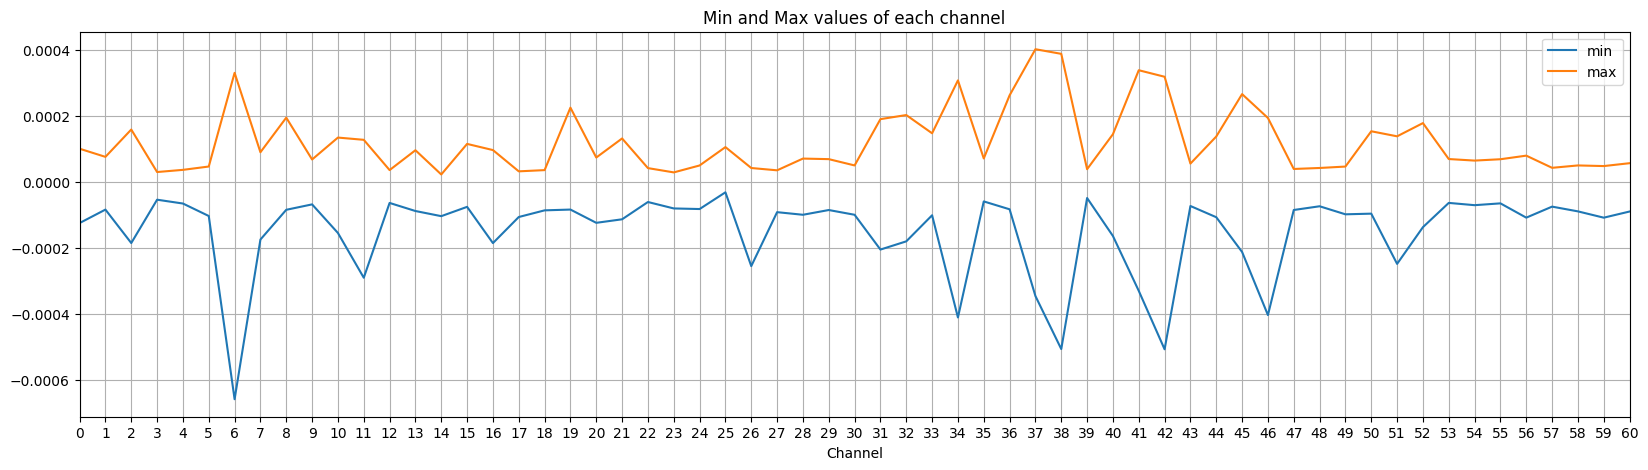

In [45]:
# get min and max values of the signal of each channel
min_values = [np.min(example[i]) for i in range(61)]
max_values = [np.max(example[i]) for i in range(61)]

plt.figure(figsize=(20, 5))
plt.plot(min_values, label='min')
plt.plot(max_values, label='max')
plt.legend()
plt.xlabel("Channel")
plt.xticks(range(0, 61))
plt.xlim(0, 60)

plt.grid()
plt.title("Min and Max values of each channel")
